✅ Fetched real EUR/USD data
Total Rows: 1000
                              open     high      low    close  volume
time                                                                 
2025-06-30 06:00:00+00:00  1.17266  1.17509  1.17209  1.17434    9542
2025-06-30 07:00:00+00:00  1.17433  1.17433  1.17247  1.17248   10400
2025-06-30 08:00:00+00:00  1.17244  1.17306  1.17137  1.17296   11032
2025-06-30 09:00:00+00:00  1.17294  1.17328  1.17174  1.17195    8619
2025-06-30 10:00:00+00:00  1.17196  1.17241  1.17166  1.17202    4882


39it [00:04,  8.33it/s]
14it [00:03,  3.84it/s]
14it [00:04,  3.16it/s]
14it [00:04,  2.98it/s]


Rows After Feature Engineering: 1000

🔍 Starting Triple Barrier Labeling...


✅ Found good labels after 1 attempts.
 1    579
-1    322
 0     79
Name: count, dtype: int64

📊 Final Label Distribution:
target
2    579
0    322
1     79
Name: count, dtype: int64


C:\Users\Lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:48:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.78      0.61        49
           1       0.00      0.00      0.00        17
           2       0.82      0.74      0.78       130

    accuracy                           0.68       196
   macro avg       0.44      0.50      0.46       196
weighted avg       0.67      0.68      0.67       196


🧾 Confusion Matrix:
[[38  0 11]
 [ 7  0 10]
 [31  3 96]]

🌳 Top 10 Important Features:
KCBe_20_2               0.063064
DPO_20                  0.035935
RVGI_14_4               0.032932
ACCBL_20                0.030696
ACCBM_20                0.028932
QQE_14_5_4.236_RSIMA    0.026132
WILLR_14                0.024073
ABER_XG_5_15            0.022317
BBU_5_2.0               0.020268
THERMOma_20_2_0.5       0.020033
dtype: float32


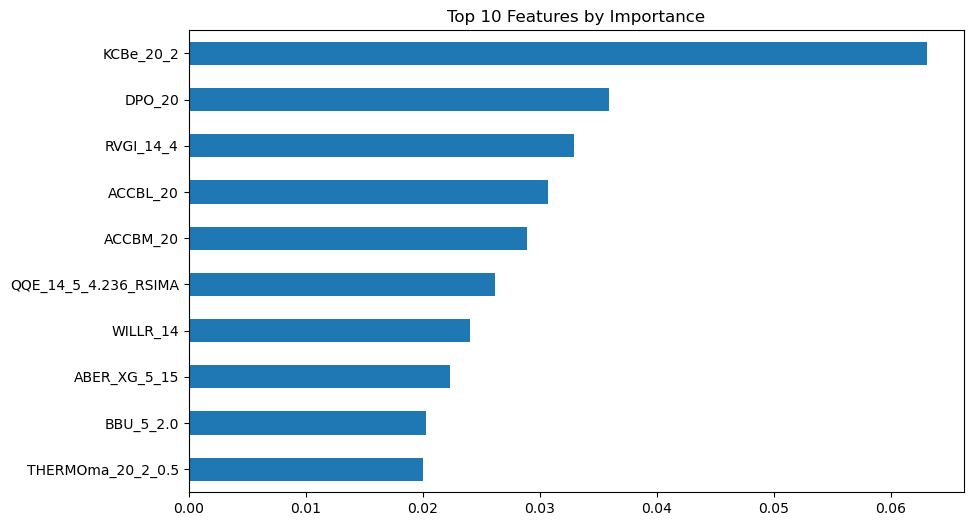


✅ Saved labeled dataset to: EURUSD_with_labels.csv


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from oandapyV20 import API
from oandapyV20.endpoints.instruments import InstrumentsCandles
import pandas_ta as ta
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# --- Step 1: Fetch Real EUR/USD Data from OANDA ---
access_token = "32a7ce5d62167ef2dda800802386d48a-496bae9b01506113e0a75dbac8e7a693"
client = API(access_token=access_token, environment="practice")

def fetch_eurusd_data(granularity="H1", count=1000):
    params = {"granularity": granularity, "count": count}
    ep = InstrumentsCandles(instrument="EUR_USD", params=params)
    client.request(ep)

    data = [{
        'time': candle['time'],
        'open': float(candle['mid']['o']),
        'high': float(candle['mid']['h']),
        'low': float(candle['mid']['l']),
        'close': float(candle['mid']['c']),
        'volume': candle['volume']
    } for candle in ep.response.get('candles', [])]

    df = pd.DataFrame(data)
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    return df

df = fetch_eurusd_data()
print("✅ Fetched real EUR/USD data")
print(f"Total Rows: {len(df)}")
print(df.tail())

# --- Step 2: Feature Engineering ---
df.ta.strategy("Momentum")
df.ta.strategy("Volatility")
df.ta.strategy("Trend")
df.ta.strategy("Volume")

# Custom Features
df['log_return'] = np.log(df['close'] / df['close'].shift(1))
df['volatility_20'] = df['log_return'].rolling(window=20).std()
df['return_1d'] = df['close'].pct_change(1).fillna(0)
df['return_5d'] = df['close'].pct_change(5).fillna(0)
df['day_of_week'] = df.index.dayofweek
df['month_of_year'] = df.index.month

# Fill missing values
df.bfill(inplace=True)

print(f"Rows After Feature Engineering: {len(df)}")

# --- Step 3: Triple Barrier Labeling Function (with fallback) ---
def apply_triple_barrier(close, volatility, sl_factor=2.0, tp_factor=2.0, max_period=20, max_attempts=5):
    print("\n🔍 Starting Triple Barrier Labeling...\n")
    for attempt in range(max_attempts):
        labels = []

        for i in range(len(close) - max_period):
            base_price = close.iloc[i]
            vol = volatility.iloc[i]

            upper = base_price + tp_factor * base_price * vol
            lower = base_price - sl_factor * base_price * vol

            future_prices = close.iloc[i:i + max_period]

            touch_upper = (future_prices >= upper).any()
            touch_lower = (future_prices <= lower).any()

            if touch_upper:
                labels.append(1)
            elif touch_lower:
                labels.append(-1)
            else:
                labels.append(0)

        label_series = pd.Series(labels, index=close.index[:len(labels)])

        if len(label_series.unique()) >= 2:
            print(f"\n✅ Found good labels after {attempt + 1} attempts.")
            print(label_series.value_counts())
            return label_series

        print(f"🔁 Attempt {attempt + 1}: Only one label found. Lowering thresholds...")
        sl_factor *= 0.8
        tp_factor *= 0.8

    # Fallback: Use simple direction labeling
    print("\n⚠️ Could not find usable Triple Barrier labels. Falling back to simple direction labeling.")
    simple_labels = np.sign(close.pct_change(periods=max_period).shift(-max_period)).fillna(0).astype(int)
    print("📊 Simple Label Distribution:\n", simple_labels.value_counts())
    return simple_labels

# Apply labeling
df['target'] = apply_triple_barrier(df['close'], df['volatility_20'], max_period=20)
df.dropna(inplace=True)

# --- NEW LINE: Map -1, 0, 1 → to 0, 1, 2 (or just 0 and 1 for binary) ---
df['target'] = df['target'].map({-1: 0, 0: 1, 1: 2})  # Change to suit your strategy

print(f"\n📊 Final Label Distribution:\n{df['target'].value_counts()}")

# --- Step 5: Check if Labels Are Usable Before Training ---
if len(df['target'].unique()) < 2:
    raise ValueError("""
    ❌ Not enough variation in labels — try increasing max_period or using a more volatile pair.
    """)

# Proceed only if labels exist
features = [col for col in df.columns if col not in ['target', 'open', 'high', 'low', 'close', 'volume']]
X = df[features]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_scaled, y_train)

preds = model.predict(X_test_scaled)

# --- Step 6: Evaluate ---
print("\n📊 Classification Report:")
print(classification_report(y_test, preds))

print("\n🧾 Confusion Matrix:")
print(confusion_matrix(y_test, preds))

# --- Step 7: Feature Importance ---
fi = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n🌳 Top 10 Important Features:")
print(fi.head(10))

plt.figure(figsize=(10, 6))
fi.sort_values().tail(10).plot(kind='barh', title="Top 10 Features by Importance")
plt.show()

# --- Step 8: Save Dataset ---
df.to_csv("EURUSD_with_labels.csv")
print("\n✅ Saved labeled dataset to: EURUSD_with_labels.csv")

In [15]:
# Keep only up/down samples
df_binary = df[df['target'] != 1]  # remove neutral
df_binary['target'] = df_binary['target'].map({0: 0, 2: 1})

# Retrain on just two classes
X = df_binary[features]
y = df_binary['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_scaled, y_train)

preds = model.predict(X_test_scaled)

print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12152\1240445035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary['target'] = df_binary['target'].map({0: 0, 2: 1})
C:\Users\Lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:51:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.62      0.78      0.69        51
           1       0.91      0.81      0.85       130

    accuracy                           0.80       181
   macro avg       0.76      0.80      0.77       181
weighted avg       0.82      0.80      0.81       181

[[ 40  11]
 [ 25 105]]


In [ ]:
Predicting EURUSD Direction Using Triple Barrier Labeling  Machine Learning A Quantitative Approach to FX Risk Management with 0.68 Accuracy and 0.82 Precision on Up Moves 